.. _nb_mixed_variable:

## Mixed Variable Problem

In some cases variable might have different types, some might be real and others integer valued. For those cases, different evolutionary operators must be applied to different type of variables. In *pymoo* this is supported by instantiating operators with a mask. Let us consider the following optimization problem with two variables:


In [1]:
import numpy as np

from pymoo.model.problem import Problem

class MyProblem(Problem):

    def __init__(self):
        super().__init__(n_var=2, n_obj=1, n_constr=1, xl=0, xu=10)

    def _evaluate(self, x, out, *args, **kwargs):
        out["F"] = - np.min(x * [3, 1], axis=1)
        out["G"] = x[:, 0] + x[:, 1] - 10

Where we would like to keep the first variable in integer and the second variable a real value. Therefore, we first define a mask that defines the type for each variable:

In [2]:
# if the first variable is an integer and the second a real value
mask = ["int", "real"]

# e.g. if first two are integers and third real it would be
# mask = ["int", "int", real"]
# for the purpose of plotting we limit us to two variables here

Furthermore, all operators which are necessary to run the algorithm must be defined. The mixed variable classes allow to reuse existing operator and apply in inside the mask during running time. The keys of the dictionary must match with the keywords used in the mask. Internally, the mating considers each type of the mask separately, applies the operator and finally concatenates the results. 

In [3]:
from pymoo.factory import get_sampling, get_crossover, get_mutation
from pymoo.operators.mixed_variable_operator import MixedVariableSampling, MixedVariableMutation, MixedVariableCrossover

sampling = MixedVariableSampling(mask, {
    "real": get_sampling("real_random"),
    "int": get_sampling("int_random")
})

crossover = MixedVariableCrossover(mask, {
    "real": get_crossover("real_sbx", prob=1.0, eta=3.0),
    "int": get_crossover("int_sbx", prob=1.0, eta=3.0)
})

mutation = MixedVariableMutation(mask, {
    "real": get_mutation("real_pm", eta=3.0),
    "int": get_mutation("int_pm", eta=3.0)
})

Finally, as usual the optimization method is called with the operators defined above:

In [4]:
import numpy as np

from pymoo.algorithms.so_genetic_algorithm import GA
from pymoo.factory import get_crossover, get_mutation, get_sampling
from pymoo.optimize import minimize

problem = MyProblem()

algorithm = GA(
    pop_size=20,
    sampling=sampling,
    crossover=crossover,
    mutation=mutation,
    eliminate_duplicates=True,
)

res = minimize(
    problem,
    algorithm,
    ('n_gen', 200),
    seed=1,
    save_history=True
)

print("Best solution found: %s" % res.X)
print("Function value: %s" % res.F)
print("Constraint violation: %s" % res.CV)


Best solution found: [3 6.994769535604938]
Function value: [-6.994769535604938]
Constraint violation: [-0.0]


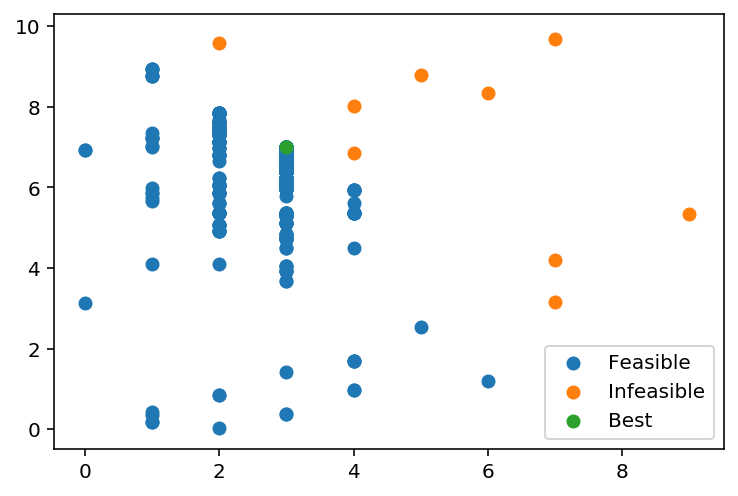

In [5]:
import matplotlib.pyplot as plt
from pymoo.util import plotting

_X = np.row_stack([a.pop.get("X") for a in res.history])
feasible = np.row_stack([a.pop.get("feasible") for a in res.history])[:, 0]

plotting.plot(_X[feasible], _X[np.logical_not(feasible)], res.X[None,:]
              , labels=["Feasible", "Infeasible", "Best"])